### Song based sentiment analysis using Textblob

In [25]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [26]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/outData.csv')

## Get a balanced sample of n songs per genre

In [27]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres

In [28]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(500).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,[ Both ] He turned the water into wine he turn...
1,Country,"Sometimes she runs, sometimes she don't More t..."
2,Country,On Saturday night when our work is done We loa...
3,Country,How do I Break it to my heart That it's gotta ...
4,Country,Chorus: A heartsong melody play like a symphon...
5,Country,My lonely heart was waitin' You came right on ...
6,Country,I love you I'll prove it in days to come I swe...
7,Country,"Hey there, weird kid in your high-top shoes Si..."
8,Country,I walked down to the park last night Warm bree...
9,Country,Written by billy burnette. I miss you darling ...


## Remove punctuation/lower casing

In [29]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Remove stopwords and Tokenize

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
song_data_processed['Sentiment'] = song_data_processed['Lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
song_data_processed['Subjectivity'] = song_data_processed['Lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [32]:
song_data_processed

,Genre,Lyrics,Sentiment,Subjectivity
0,Country,[ both ] he turned the water into wine he turn...,-0.296875,0.675000
1,Country,sometimes she runs sometimes she don't more th...,-0.083796,0.492593
2,Country,on saturday night when our work is done we loa...,-0.121539,0.498391
3,Country,how do i break it to my heart that it's gotta ...,0.240603,0.465263
4,Country,chorus: a heartsong melody play like a symphon...,0.242794,0.428163
...,...,...,...,...
4995,Rock,slutkiss girls\nwon't you promise her smack\ni...,-0.313194,0.851389
4996,Rock,love hurts love scars love wounds' and marks\n...,0.383183,0.543694
4997,Rock,when mr\nbrown said he felt good\ni tell you i...,0.309821,0.511685
4998,Rock,if you want me to listen whisper\nif you want ...,0.028571,0.645238


### Explore the results

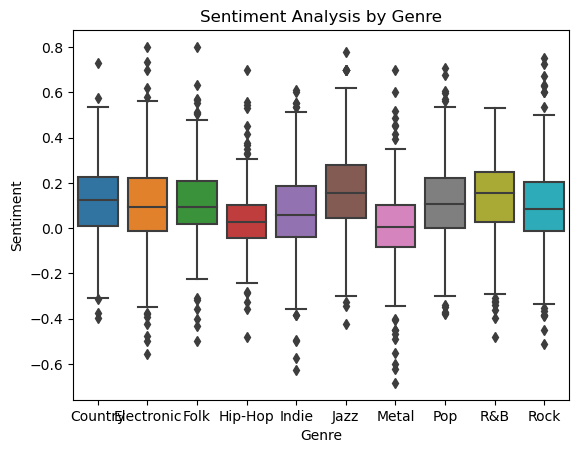

In [33]:
sns.boxplot(x='Genre', y='Sentiment', data=song_data_processed)
plt.title('Sentiment Analysis by Genre')
plt.show()

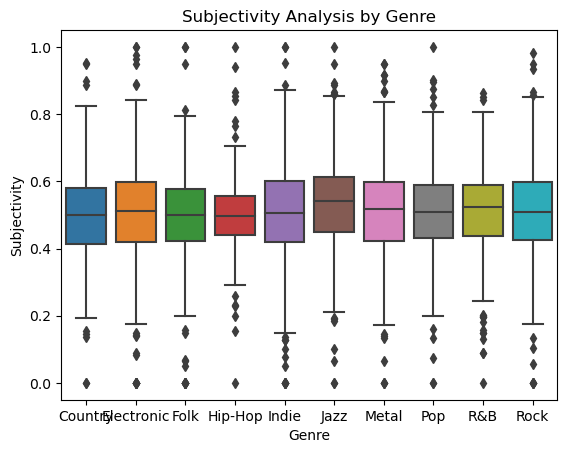

In [34]:
sns.boxplot(x='Genre', y='Subjectivity', data=song_data_processed)
plt.title('Subjectivity Analysis by Genre')
plt.show()

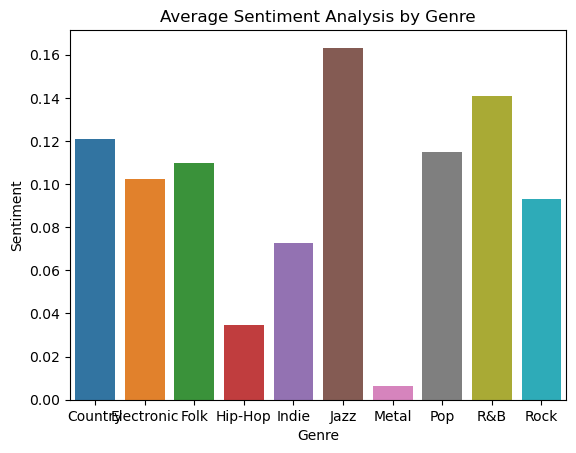

In [35]:
sns.barplot(x='Genre', y='Sentiment', data=song_data_processed, errorbar=None)
plt.title('Average Sentiment Analysis by Genre')
plt.show()

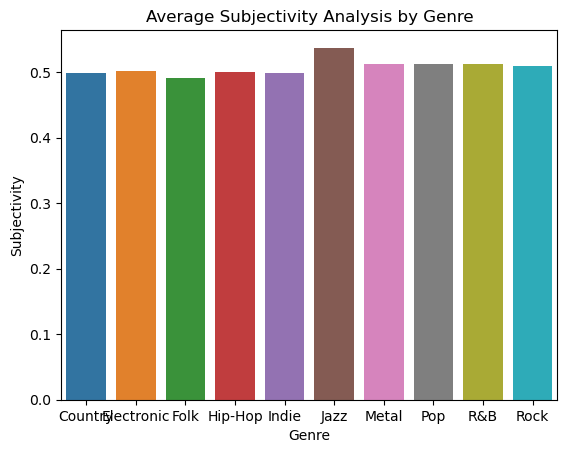

In [36]:
sns.barplot(x='Genre', y='Subjectivity', data=song_data_processed, errorbar=None)
plt.title('Average Subjectivity Analysis by Genre')
plt.show()

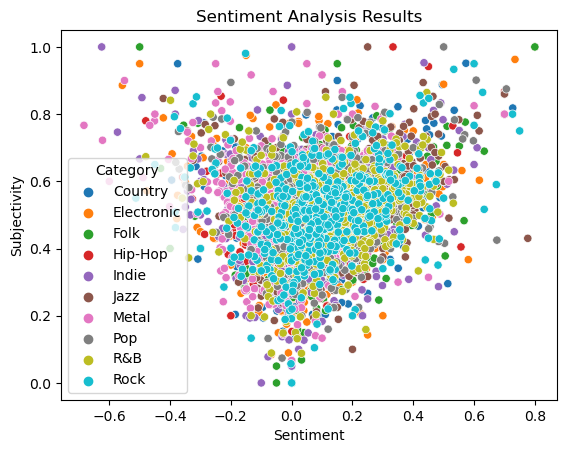

In [37]:
#Scatter Plot
sns.scatterplot(x='Sentiment', y='Subjectivity', hue='Genre', data=song_data_processed)
plt.title('Sentiment Analysis Results')
plt.legend(title='Category')
plt.show()

## Trying classification

In [38]:
X = song_data_processed[["Sentiment", "Subjectivity"]]
label_encoder = LabelEncoder()
song_data_processed["GenreID"] = label_encoder.fit_transform(song_data_processed["Genre"])
y = song_data_processed["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.12866666666666668

In [45]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.14466666666666667

In [41]:
#Random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.13066666666666665

### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Anwendung der sentiment analyse mithilfe der python textblob bibliothekt (Ergebnis in form von polarity & subjectivity)
- Investigating whether there is a correlation between the sentiments and the song genres, using boxplots, barcharts and Scatterplots
- Investigating whether it is possible to predict a genre based on its sentiments

### Ergebnis
- Die meisten songgenres können grundsätzlich positive als auch negative grundsentiments haben
- vor allem Metall und HipHop sind tendenziell eher negativer (was erwartungsgemäß ist), dieser unterschied ist jedoch nicht extrem groß
- Tendenziell sind song sentiments eher positiv
- Im bezug auf subjektivität sind die meisten songs eher neutral (und auch ähnlich neutral)
- Der Scatterplot zeigt, dass durch Sentiment und Subjektivität alleine keine differenzierung der songgenres möglich ist
- Dieses Ergebnis wird bestätigt durch die Anwendung verschiedener Klassifikationsverfahren, die maximal eine accuracy von 0.14 haben

### Interpretation
- Obwohl wenige genres tendenziell negativer sind, kann man grundsätzlich vom Song basierten sentiment nicht auf die gesamtheit eines genres schließen. dafür sind lieder innerhalb von genres zu unterschiedlich in ihrer grundstimmung
